In [2]:
import pandas as pd
import numpy as np
from urllib.request import urlopen

game_stats = pd.read_csv('https://www.football-data.co.uk/mmz4281/2021/E1.csv')

#description of each abbreviation
columns_meaning_page = urlopen("https://www.football-data.co.uk/notes.txt").read().decode('utf-8')
#print(columns_meaning_page)

#rearranging realtime dates to tours, some games may be assigned next or previous tour, it is not significant
#deleting (supposedly) less informative columns, also removing betting odds (idea is to unveil statistical game factors, not odds)
game_stats = game_stats.loc[:, game_stats.columns.isin(['Date','HomeTeam','AwayTeam','FTHG','FTAG','HTHG','HTAG','HS','AS','HST','AST','HC','AC','HF','AF','HY','AY','HR','AR'])]
game_stats['Tour'] = ((pd.to_datetime(game_stats.Date, dayfirst = True) - pd.to_datetime(game_stats.Date[0], dayfirst = True)).dt.days // 7)
game_stats = game_stats.drop(columns = 'Date')
game_stats_tour = game_stats.loc[game_stats.Tour == 0]
game_stats_next_tour = game_stats.loc[game_stats.Tour == 1]
game_stats_tour.head(5)



,HomeTeam,AwayTeam,FTHG,FTAG,HTHG,HTAG,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR,Tour
0,Watford,Middlesbrough,1,0,1,0,10,11,2,4,13,14,6,6,1,0,0,0,0
1,Birmingham,Brentford,1,0,1,0,11,16,3,4,16,11,6,3,4,1,0,0,0
2,Wycombe,Rotherham,0,1,0,0,10,12,4,2,12,19,3,4,1,1,0,0,0
3,Barnsley,Luton,0,1,0,0,10,3,1,1,14,10,5,6,1,3,0,0,0
4,Bournemouth,Blackburn,3,2,1,1,12,15,5,2,12,16,5,2,2,0,0,0,0


In [3]:
#rearranging game statistics into each team's statistic
def update_table(team_stats, game_stats_tour):
    for team in game_stats_tour.HomeTeam:
        team_stats.loc[team].FTHG += game_stats_tour.where(game_stats_tour.HomeTeam == team).FTHG.dropna().iloc[0].astype(int)
        team_stats.loc[team].HTHG += game_stats_tour.where(game_stats_tour.HomeTeam == team).HTHG.dropna().iloc[0].astype(int)
        team_stats.loc[team].HS += game_stats_tour.where(game_stats_tour.HomeTeam == team).HS.dropna().iloc[0].astype(int)
        team_stats.loc[team].HST += game_stats_tour.where(game_stats_tour.HomeTeam == team).HST.dropna().iloc[0].astype(int)
        team_stats.loc[team].HC += game_stats_tour.where(game_stats_tour.HomeTeam == team).HC.dropna().iloc[0].astype(int)
        team_stats.loc[team].HF += game_stats_tour.where(game_stats_tour.HomeTeam == team).HF.dropna().iloc[0].astype(int)
        team_stats.loc[team].HY += game_stats_tour.where(game_stats_tour.HomeTeam == team).HY.dropna().iloc[0].astype(int) 
        team_stats.loc[team].HR += game_stats_tour.where(game_stats_tour.HomeTeam == team).HR.dropna().iloc[0].astype(int)   
    
    for team in game_stats_tour.AwayTeam:
        team_stats.loc[team].FTAG += game_stats_tour.where(game_stats_tour.AwayTeam == team).FTAG.dropna().iloc[0].astype(int)
        team_stats.loc[team].HTAG += game_stats_tour.where(game_stats_tour.AwayTeam == team).HTAG.dropna().iloc[0].astype(int)
        team_stats.loc[team].AS += game_stats_tour.where(game_stats_tour.AwayTeam == team).AS.dropna().iloc[0].astype(int)
        team_stats.loc[team].AST += game_stats_tour.where(game_stats_tour.AwayTeam == team).AST.dropna().iloc[0].astype(int)
        team_stats.loc[team].AC += game_stats_tour.where(game_stats_tour.AwayTeam == team).AC.dropna().iloc[0].astype(int)
        team_stats.loc[team].AF += game_stats_tour.where(game_stats_tour.AwayTeam == team).AF.dropna().iloc[0].astype(int)
        team_stats.loc[team].AY += game_stats_tour.where(game_stats_tour.AwayTeam == team).AY.dropna().iloc[0].astype(int) 
        team_stats.loc[team].AR += game_stats_tour.where(game_stats_tour.AwayTeam == team).AR.dropna().iloc[0].astype(int)    
  

In [6]:
epoch = 0
game_stats_tour = game_stats.loc[game_stats.Tour == epoch]
game_stats_next_tour = game_stats.loc[game_stats.Tour == epoch + 1]

#initialising team_stats_table
team_stats = pd.DataFrame(index = [team for team in game_stats_tour.AwayTeam] + [team for team in game_stats_tour.HomeTeam], 
columns = ['FTHG','FTAG','HTHG','HTAG','HS','AS','HST','AST','HC','AC','HF','AF','HY','AY','HR','AR']).fillna(0).astype(int)

update_table(team_stats, game_stats_tour) #stats for epoch 0 so far 
team_stats.head(3)
#print(np.array(team_stats.loc['Brentford'].values.tolist()))
#game_stats_next_tour.AwayTeam.head(5)

,FTHG,FTAG,HTHG,HTAG,HS,AS,HST,AST,HC,AC,HF,AF,HY,AY,HR,AR
Middlesbrough,0,0,0,0,0,11,0,4,0,6,0,14,0,0,0,0
Brentford,0,0,0,0,0,16,0,4,0,3,0,11,0,1,0,0
Rotherham,0,1,0,0,0,12,0,2,0,4,0,19,0,1,0,0


Оценка значения производится простым скалярным произведением: $ \overline{g} = w^{T} x $, $w$ - веса, $x$ - показатели команды, FTHG, FTAG etc. После матча мы узнаем реальное значение $ g $, функция ошибок $ L = (\overline{g} - g)^2 =  (w^{T} x - g)^{2} $. Скорректируем веса $$ \forall i \hspace{0.2cm} w_{i} \rightarrow  w_{i} - \eta \dfrac{\partial L}{\partial w_{i}}, $$
где $\eta$ - скорость обучения. В таком простом случае $\dfrac{\partial L}{\partial w_{i}} = 2(w^{T} x - g) x_{i}$


In [24]:
def forward_prop(weights, team):
    values = team_stats.loc[team].tolist()
    max_values, normalized_values = [], [0 for i in range(len(values))]
    for column in team_stats.columns.tolist():
        max_values.append(max(team_stats[column]))
    
    for i in range(len(values)):
        if(max_values[i] >= 1):
            normalized_values[i] = values[i] / max_values[i]
        else: 
            normalized_values[i] = values[i]
    
    return np.dot(np.array(normalized_values), weights[team])

def back_prop(weights, team, measurement, aprior_estimation):
    learning_rate = 0.005
    return weights[team] - 2.0*(aprior_estimation - measurement)*np.array(team_stats.loc[team].values.tolist())*learning_rate


In [29]:
Weights, initial_weights = dict(), [np.random.rand() for x in range(16)]
for team in team_stats.index.values.tolist():
    Weights.update({team : np.array(initial_weights / np.sqrt(np.sum(np.square(initial_weights))))})
    #print(Weights[team])

epoch, error = 0, []
game_stats_tour = game_stats.loc[game_stats.Tour == epoch]
game_stats_next_tour = game_stats.loc[game_stats.Tour == epoch + 1]

#initialising team_stats_table
team_stats = pd.DataFrame(index = [team for team in game_stats_tour.AwayTeam] + [team for team in game_stats_tour.HomeTeam], 
columns = ['FTHG','FTAG','HTHG','HTAG','HS','AS','HST','AST','HC','AC','HF','AF','HY','AY','HR','AR']).fillna(0).astype(int)
team = 'Blackburn'
for epoch in range(0, 26):
    game_stats_tour = game_stats.loc[game_stats.Tour == epoch]
    game_stats_next_tour = game_stats.loc[game_stats.Tour == epoch + 1]
    update_table(team_stats, game_stats_tour)    
    #team_stats.head(1)
    
    if(team in game_stats_next_tour.HomeTeam.tolist()):
        measurement = game_stats_next_tour.where(game_stats_next_tour.HomeTeam == team).FTHG.dropna().iloc[0].astype(int)
    elif(team in game_stats_next_tour.AwayTeam.tolist()):
        measurement = game_stats_next_tour.where(game_stats_next_tour.AwayTeam == team).FTAG.dropna().iloc[0].astype(int)
    else:
        print('team result not found, epoch = ', epoch)
        continue
     
    aprior_estimation = forward_prop(Weights, team)
    if(aprior_estimation < 0.0):
        aprior_estimation = 0.0
    
    aposterior_weights = back_prop(Weights, team, measurement, aprior_estimation)
    error.append(round(aprior_estimation - measurement))
    print(measurement, round(aprior_estimation, 2), np.around(aposterior_weights, 2))
    #print(np.round(np.array(error), 2))
    
    for team in team_stats.index.values.tolist():
        Weights.update({team : aposterior_weights / np.sqrt(np.sum(np.square(aposterior_weights)))})    

5 0.96 [0.12 0.25 0.35 0.46 0.09 1.05 0.49 0.22 0.07 0.33 0.15 0.71 0.16 0.27
 0.02 0.08]
1 1.31 [0.07 0.15 0.22 0.29 0.03 0.63 0.3  0.13 0.03 0.19 0.05 0.41 0.1  0.16
 0.01 0.05]
1 0.94 [0.07 0.16 0.23 0.3  0.04 0.67 0.32 0.14 0.04 0.2  0.07 0.44 0.1  0.17
 0.01 0.05]
team result not found, epoch =  3
0 1.34 [ 0.03  0.11  0.21  0.28 -0.27  0.45  0.18  0.05 -0.11  0.06 -0.26  0.11
  0.09  0.13  0.01  0.05]
0 0.36 [ 0.03  0.14  0.28  0.37 -0.46  0.51  0.21  0.04 -0.19  0.01 -0.48  0.01
  0.11  0.15  0.02  0.07]
3 0.0 [0.12 0.23 0.3  0.39 0.87 1.46 0.53 0.34 0.29 0.67 0.86 1.48 0.17 0.32
 0.02 0.1 ]
1 1.7 [ 0.    0.06  0.09  0.14 -0.07  0.22  0.08  0.04 -0.06  0.05 -0.06  0.13
  0.02  0.08  0.01  0.03]
team result not found, epoch =  8
1 1.1 [-0.    0.15  0.25  0.39 -0.25  0.56  0.2   0.08 -0.2   0.11 -0.23  0.29
  0.05  0.21  0.02  0.08]
1 0.59 [ 0.03  0.18  0.28  0.41  0.08  0.82  0.31  0.16 -0.05  0.26  0.1   0.59
  0.09  0.26  0.02  0.09]
0 1.56 [-0.12  0.05  0.16  0.3  -1.55 -0.4  -

[-4.  0. -0.  1.  0. -3.  1.  0. -0.  2.  0. -1.  2. -2.  1.  0. -2.  1.
 -2. -0.  1. -1.  2.]


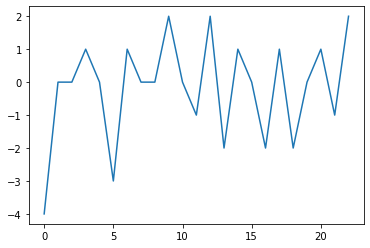

In [30]:
import matplotlib.pyplot as plt 

print(np.round(np.array(error), 2))
epoches = np.arange(0, len(error), 1)
plt.plot(epoches, error)
plt.show()

In [ ]:
class team_weights:
    def __init__(self, name, FTAG = 1, HTAG = 1, AS = 0.1, AST = 0.3, AF = 0, AC = 0.1, AY = 0.5, AR = 1, FTHG = 1, HTHG = 0.5, 
                 HS = 0.1, HST = 0.3, HF = 0.1, HC = 0.1, HY = 0.5, HR = 1):
            self._name = name
            self._away_full_time_goals = FTAG
            self._away_half_time_goals = HTAG
            self._away_shots = AS
            self._away_shot_on_target = AST
            self._away_fouls = AF
            self._away_corners = AC
            self._away_yellow_cards = AY
            self._away_red_cards = AR
            self._home_full_time_goals = FTHG
            self._home_half_time_goals = HTHG
            self._home_shots = HS
            self._home_shot_on_target = HST
            self._home_fouls = HF
            self._home_corners = HC
            self._home_yellow_cards = HY
            self._home_red_cards = HR
    
    def get_away_full_time_goals(self):
            return self._away_full_time_goals
    
    def get_away_half_time_goals(self):
            return self._away_half_time_goals
    
    def get_away_shots(self):
            return self._away_shots
        
    def get_away_shot_on_target(self):
            return self._away_shot_on_target
    
    def get_away_fouls(self):
            return self._away_fouls
    
    def get_away_corners(self):
            return self._away_corners
        
    def get_away_yellow_cards(self):
            return self._away_yellow_cards
        
    def get_away_red_cards(self):    
            return self._away_red_cards
    
    def get_home_full_time_goals(self):     
            return self._home_full_time_goals
        
    def get_home_half_time_goals(self):
            return self._home_half_time_goals
    
    def get_home_shots(self):   
            return self._home_shots
        
    def get_home_shot_on_target(self):    
            return self._home_shot_on_target
        
    def get_home_fouls(self):
            return self._home_fouls
    
    def get_home_corners(self):
            return self._home_corners
    
    def get_home_yellow_cards(self):
            return self._home_yellow_cards
    
    def get_home_red_cards(self):
            return self._home_red_cards
    

    
   